In [1]:
%pip install -q git+https://github.com/yfukai/BaSiCPy@autosegment

Note: you may need to restart the kernel to use updated packages.


# Install and import 

In [1]:
workdir = "/work/fukai/basicpy"

In [2]:
import numpy as np
import pandas as pd
from basicpy import BaSiC, datasets, metrics
from itertools import product
from tqdm import tqdm
from matplotlib import pyplot as plt
import pickle
from os import path
from skimage import filters

plt.rcParams["font.family"] = ""

In [3]:
with open(path.join(workdir, "wo_darkfield_imagess.pickle"), "rb") as f:
    imagess = pickle.load(f)

In [12]:
parameters_df = pd.read_csv(path.join(workdir, "wo_darkfield_parameters.csv"))

# Calculate deviation

In [5]:
flatfields = np.load("flatfields.npy")

In [13]:
estimated_parameters_df = pd.read_csv(
    "wo_flatfield_estimated_parameters_df.csv", index_col=0
)

In [14]:
assert len(estimated_parameters_df) == len(flatfields)
set(estimated_parameters_df.keys())

{'ave_count',
 'blob_dist_key',
 'deviation',
 'fitting_mode',
 'image_index',
 'intensity',
 'n_images',
 'rep',
 'smoothness_flatfield',
 'time',
 'true_flatfield_id'}

In [15]:
keys

['fitting_mode']

/tmp/ipykernel_151957/2512475063.py:29: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
findfont: Font family [] not found. Falling back to DejaVu Sans.


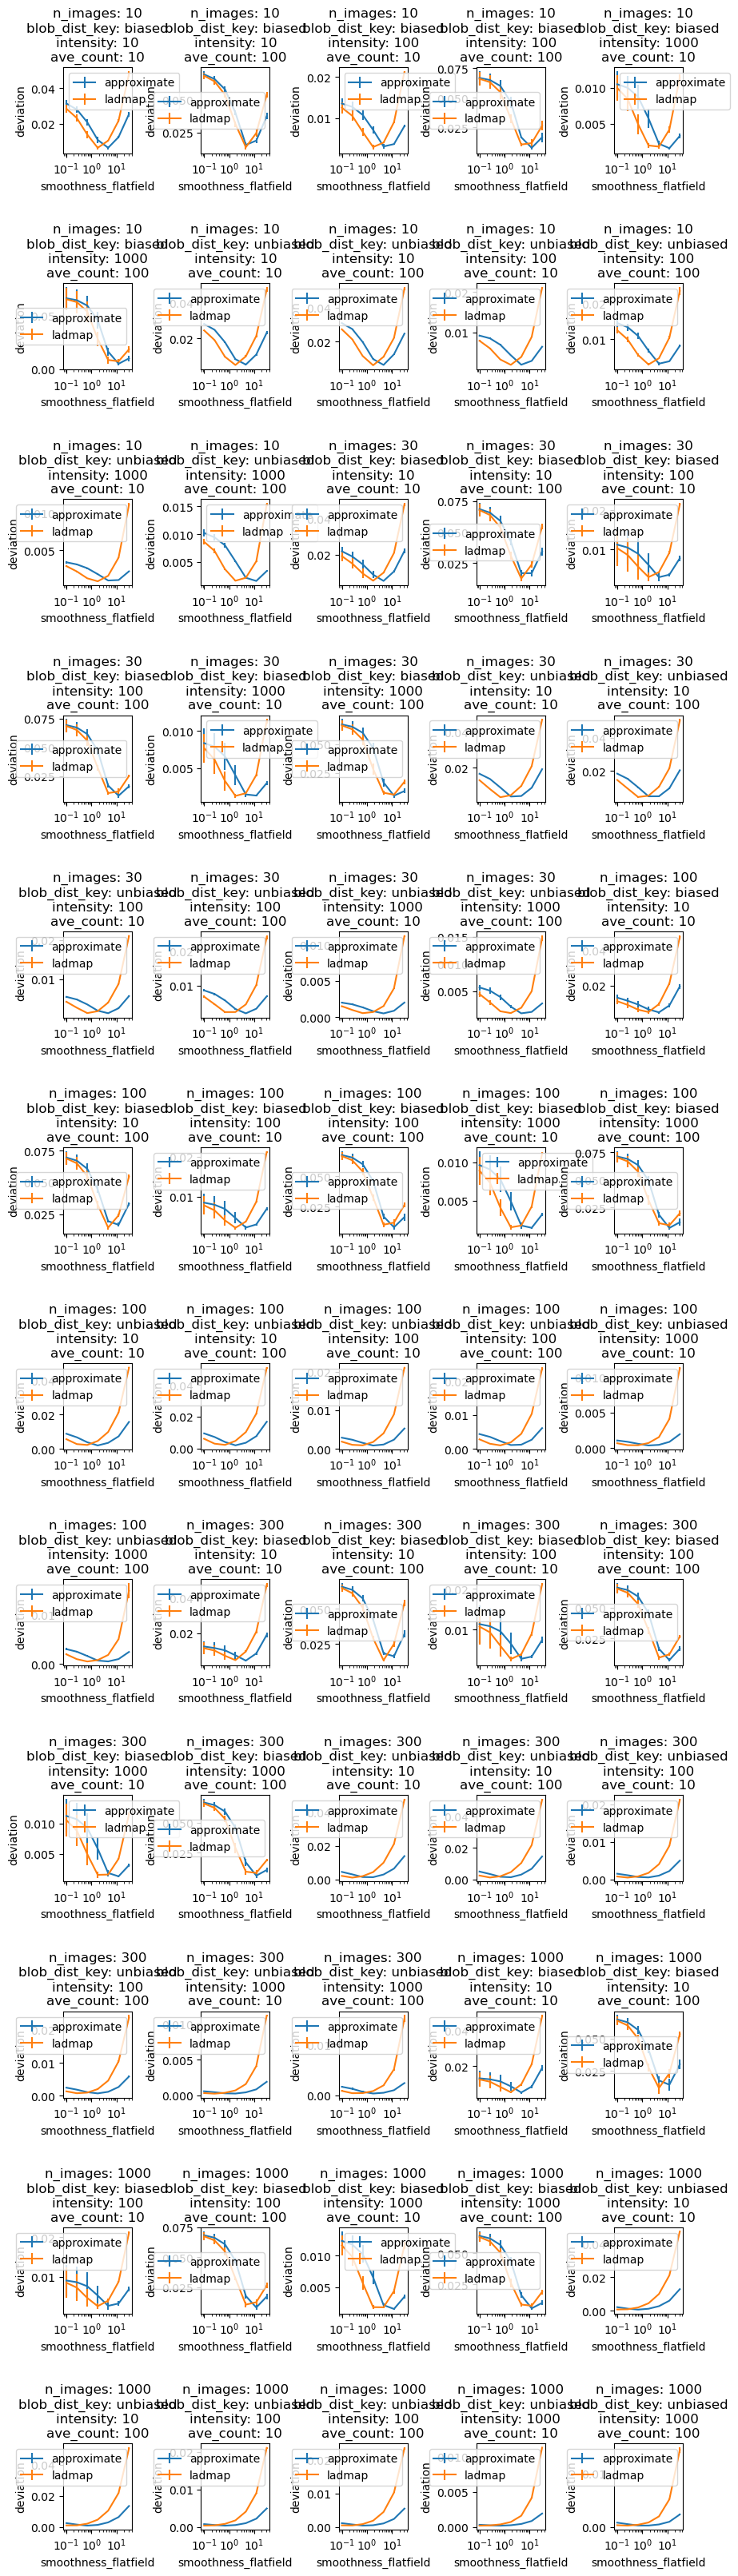

In [16]:
df = estimated_parameters_df[estimated_parameters_df["true_flatfield_id"] == 0]
image_properties = ["n_images", "blob_dist_key", "intensity", "ave_count"]
keys = list(
    set(estimated_parameters_df.keys())
    - {
        "smoothness_flatfield",
        "deviation",
        "true_flatfield_id",
        "image_index",
        "time",
        "rep",
        *image_properties,
    }
)
assert len(keys) == 1

num_imagess = df["n_images"].unique().tolist()
ncols = len(num_imagess)
grps = list(df.groupby(image_properties))
nrows = (len(grps) - 1) // ncols + 1

fig, axes = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(10, 40),
    gridspec_kw={"hspace": 1.5, "wspace": 1.0},
)
for ii, (image_property, grp0) in enumerate(df.groupby(image_properties)):
    ax = axes[ii // ncols, ii % ncols]
    for key, grp in grp0.groupby(keys[0]):
        vals = (
            grp.groupby("smoothness_flatfield")["deviation"]
            .agg(["mean", "std"])
            .reset_index()
        )
        ax.errorbar(vals["smoothness_flatfield"], vals["mean"], vals["std"], label=key)
    ax.set_title(
        "\n".join([f"{k}: {v}" for k, v in zip(image_properties, image_property)])
    )
    ax.legend()
    ax.set_xlabel("smoothness_flatfield")
    ax.set_ylabel("deviation")
    ax.set_xscale("log")
fig.tight_layout()